In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import os

## Preprocessing

In [241]:
folder_path = "/Users/oas/Downloads/benchmarking_results"
# folder_path = "/Users/oas/Documents/VOD/vod/benchmarking_results"
files = [
    os.path.join(folder_path, file)
    for file in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, file))
]
files.sort()  # Sort the files by name
newest_file = files[-1]  # Pick the newest
print(newest_file)

/Users/oas/Downloads/benchmarking_results/2024-03-05-10-20-13.csv


In [242]:
df_results = pd.read_csv(newest_file)
df_results.shape

(90, 20)

In [243]:
df_results.query("RecallMean != -1")  # ["Index parameters."].str[-40:]

,Unnamed: 0,Dataset,Index,IndexParameters,timerMasterMean,timerServerStartupMean,timerBuildIndexMean,SearchSpeedAverage,SearchSpeedP95,RecallMean,RecallAt1Mean,RecallAt10Mean,RecallAt100Mean,RecallAt1000Mean,baselineMax,baselineMean,ingestingMax,ingestingMean,benchmarkingMax,benchmarkingMean
0,0,sift-128-euclidean,"index: faiss IVF, n_partition=64, None, L2","IVF, n_partition=64, None, L2",15.444423,8.572305,1.379493,5.551177,5.638892,0.999891,0.9984,1.0000,1.0000,1.0000,493.50,493.50,NaN,NaN,1000.000,999.812195
1,1,sift-128-euclidean,"index: faiss IVF, n_partition=128, None, L2","IVF, n_partition=128, None, L2",15.685309,8.574573,1.613909,2.867646,2.884004,0.998701,0.9982,0.9998,0.9998,0.9998,493.40,493.40,NaN,NaN,1000.000,1000.000000
2,2,sift-128-euclidean,"index: faiss IVF, n_partition=256, None, L2","IVF, n_partition=256, None, L2",16.286192,8.582118,2.198738,1.676559,1.693282,0.995056,0.9977,0.9993,0.9993,0.9993,493.30,493.30,NaN,NaN,1001.000,1001.000000
3,3,sift-128-euclidean,"index: faiss IVF, n_partition=512, None, L2","IVF, n_partition=512, None, L2",17.760620,8.699001,3.556263,0.882292,0.898318,0.979676,0.9941,0.9956,0.9956,0.9956,493.50,493.50,NaN,NaN,1004.000,1003.058824
4,4,sift-128-euclidean,"index: faiss IVF, n_partition=1024, None, L2","IVF, n_partition=1024, None, L2",21.122000,8.560129,7.057724,0.495436,0.502291,0.954674,0.9888,0.9903,0.9903,0.9903,493.30,493.30,NaN,NaN,1006.000,1006.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,77,sift-128-euclidean,"index: milvus HNSW, M=4, ef_construction=32, e...","HNSW, M=4, ef_construction=32, ef_search=128, ...",175.487902,90.592472,79.810640,0.923670,1.306474,0.789474,0.8471,0.8481,0.8481,0.8481,202.78,202.78,1409.630,687.433333,1816.598,1343.205158
78,78,sift-128-euclidean,"index: milvus HNSW, M=8, ef_construction=32, e...","HNSW, M=8, ef_construction=32, ef_search=128, ...",188.595449,101.816263,81.696179,1.022615,1.373695,0.938529,0.9743,0.9757,0.9757,0.9757,172.42,172.42,1405.248,672.139385,1914.848,1569.382100
79,79,sift-128-euclidean,"index: milvus HNSW, M=16, ef_construction=32, ...","HNSW, M=16, ef_construction=32, ef_search=128,...",185.018279,91.419886,88.515254,1.022268,1.323690,0.963838,0.9879,0.9893,0.9893,0.9893,190.23,190.23,1431.846,687.373955,1957.856,1597.418800
80,80,sift-128-euclidean,"index: milvus HNSW, M=32, ef_construction=32, ...","HNSW, M=32, ef_construction=32, ef_search=128,...",184.374852,91.502572,87.787748,1.046810,1.369574,0.967160,0.9900,0.9916,0.9916,0.9916,189.39,189.39,1413.632,663.274227,2089.726,1668.744400


In [244]:
df_results = df_results.query("Index != 'None'")  # ignore failed runs
df_results = df_results.query("RecallMean != -1.0")  # ignore failed runs

In [245]:
# this should be empty
df_results[df_results.benchmarkingMean.isna()]

,Unnamed: 0,Dataset,Index,IndexParameters,timerMasterMean,timerServerStartupMean,timerBuildIndexMean,SearchSpeedAverage,SearchSpeedP95,RecallMean,RecallAt1Mean,RecallAt10Mean,RecallAt100Mean,RecallAt1000Mean,baselineMax,baselineMean,ingestingMax,ingestingMean,benchmarkingMax,benchmarkingMean


In [246]:
# extract index information
df_results["IndexProvider"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[0]
df_results["IndexType"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[1]

In [247]:
# extract search parameters from parameter string

df_hnsw_parameters = (df_results.query("IndexType == 'HNSW'")["IndexParameters"]
    .str.replace("=", ", ")
    .str.split(", ", expand=True)[[2, 4, 6, 7, 8]]
)
df_hnsw_parameters.columns = ["M", "EfConstruction", "EfSearch", "Compression", "Metric"]

df_ivf_parameters = pd.DataFrame()
# TODO fix that this makes errors when no IVF are in benchmark
df_ivf_parameters = (df_results.query("IndexType == 'IVF'")["IndexParameters"]
    .str.replace(",", "")
    .str.replace("=", " ")
    .str.split(" ", expand=True)[[2, 3, 4]]
)
df_ivf_parameters.columns = ["NPartitions", "Compression", "Metric"]
""

''

In [248]:
# add search parameters to df_results
df_parameters = df_hnsw_parameters.combine_first(df_ivf_parameters)
df_results = pd.concat((df_results, df_parameters), axis=1)

In [249]:
df_results.columns = [col[0].upper() + col[1:] for col in df_results.columns]
df_results.columns

Index(['Unnamed: 0', 'Dataset', 'Index', 'IndexParameters', 'TimerMasterMean',
       'TimerServerStartupMean', 'TimerBuildIndexMean', 'SearchSpeedAverage',
       'SearchSpeedP95', 'RecallMean', 'RecallAt1Mean', 'RecallAt10Mean',
       'RecallAt100Mean', 'RecallAt1000Mean', 'BaselineMax', 'BaselineMean',
       'IngestingMax', 'IngestingMean', 'BenchmarkingMax', 'BenchmarkingMean',
       'IndexProvider', 'IndexType', 'Compression', 'EfConstruction',
       'EfSearch', 'M', 'Metric', 'NPartitions'],
      dtype='object')

## Plotting

In [250]:
df_results.shape

(65, 28)

### Large plotly plot

In [251]:
import plotly.express as px
import plotly.graph_objects as go

# Your existing DataFrame and plot
fig = px.scatter(
    df_results,
    x="RecallMean",
    y="SearchSpeedAverage",
    hover_data=["Index","IngestingMax","BenchmarkingMean","Dataset"],
    color="IndexProvider",
    size=df_results["BenchmarkingMean"],
    symbol="Dataset"
)

# # Adding a similar scatter plot but with semi-transparency and different size mapping
# fig.add_trace(
#     go.Scatter(
#         x=df_results["Recall avg"],
#         y=df_results["Search speed avg. (ms)"],
#         mode="markers",
#         marker=dict(
#             size=df_results["ingesting_max"] / 25,  # Size based on 'ingesting_max' column
#             opacity=0.1,  # Semi-transparent markers
#             # color=fig.data[0].marker.color,  # Use the same color as the first plot
#             # line=dict(color="MediumPurple", width=2),
#         ),
#         hoverinfo="text",  # You can customize hover info as needed
#         name="Ingesting max",
#     )
# )

fig.show()

In [252]:
df_results.query("Dataset == 'gist-960-euclidean'")

,Unnamed: 0,Dataset,Index,IndexParameters,TimerMasterMean,TimerServerStartupMean,TimerBuildIndexMean,SearchSpeedAverage,SearchSpeedP95,RecallMean,...,BenchmarkingMax,BenchmarkingMean,IndexProvider,IndexType,Compression,EfConstruction,EfSearch,M,Metric,NPartitions


### Compression plot

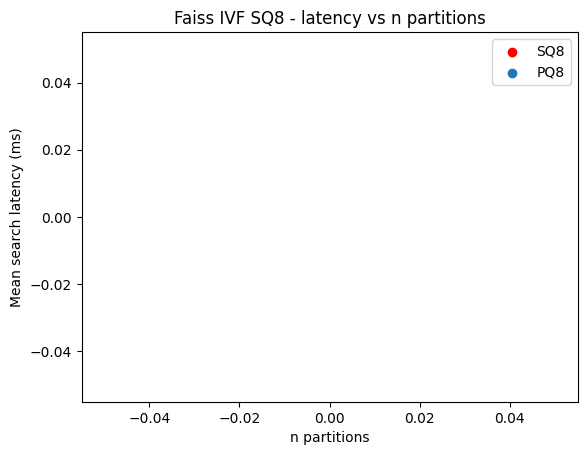

In [253]:
df_plot = df_results.query("Compression == 'SQ8'")
plt.scatter(df_plot.NPartitions, df_plot.SearchSpeedAverage/10, label="SQ8", c="red")
df_plot = df_results.query("Compression == 'PQ8'")
plt.scatter(df_plot.NPartitions, df_plot.SearchSpeedAverage / 10, label="PQ8")
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.xlabel("n partitions")
plt.ylabel("Mean search latency (ms)")
plt.legend()
plt.show()

### n partitions plot

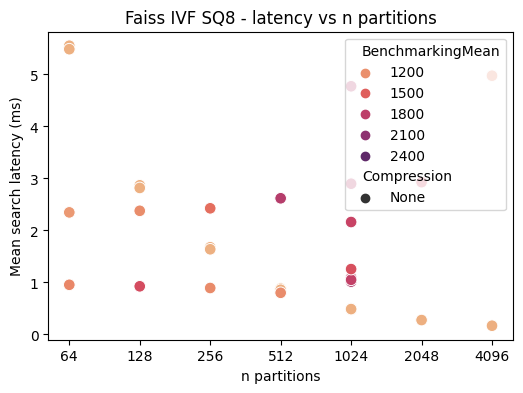

In [254]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.scatterplot(data=df_results, x="NPartitions", y="SearchSpeedAverage", hue="BenchmarkingMean", style="Compression", palette="flare", s=70)
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.xlabel("n partitions")
plt.ylabel("Mean search latency (ms)")
plt.show()

In [255]:
df_results.columns

Index(['Unnamed: 0', 'Dataset', 'Index', 'IndexParameters', 'TimerMasterMean',
       'TimerServerStartupMean', 'TimerBuildIndexMean', 'SearchSpeedAverage',
       'SearchSpeedP95', 'RecallMean', 'RecallAt1Mean', 'RecallAt10Mean',
       'RecallAt100Mean', 'RecallAt1000Mean', 'BaselineMax', 'BaselineMean',
       'IngestingMax', 'IngestingMean', 'BenchmarkingMax', 'BenchmarkingMean',
       'IndexProvider', 'IndexType', 'Compression', 'EfConstruction',
       'EfSearch', 'M', 'Metric', 'NPartitions'],
      dtype='object')

### n partions plot again

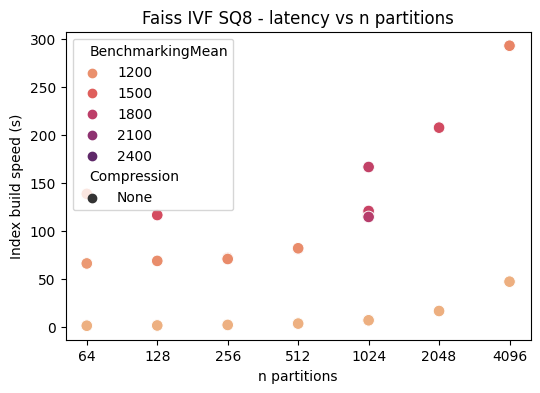

In [256]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_results,
    x="NPartitions",
    y="TimerBuildIndexMean",
    hue="BenchmarkingMean",
    style="Compression",
    palette="flare",
    s=70,
)
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.xlabel("n partitions")
plt.ylabel("Index build speed (s)")
plt.show()

In [257]:
df_results.columns

Index(['Unnamed: 0', 'Dataset', 'Index', 'IndexParameters', 'TimerMasterMean',
       'TimerServerStartupMean', 'TimerBuildIndexMean', 'SearchSpeedAverage',
       'SearchSpeedP95', 'RecallMean', 'RecallAt1Mean', 'RecallAt10Mean',
       'RecallAt100Mean', 'RecallAt1000Mean', 'BaselineMax', 'BaselineMean',
       'IngestingMax', 'IngestingMean', 'BenchmarkingMax', 'BenchmarkingMean',
       'IndexProvider', 'IndexType', 'Compression', 'EfConstruction',
       'EfSearch', 'M', 'Metric', 'NPartitions'],
      dtype='object')

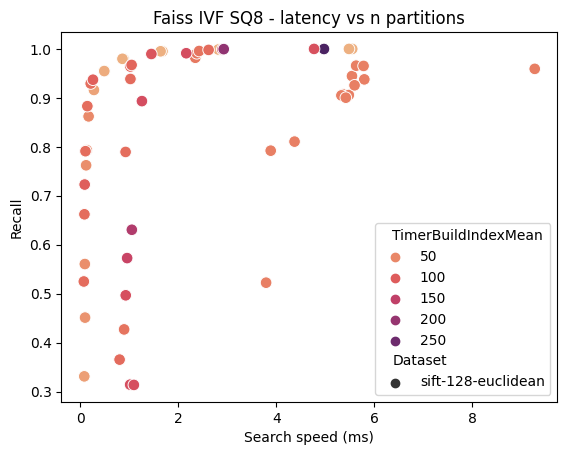

In [258]:
import seaborn as sns

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_results,
    x="SearchSpeedAverage",
    y="RecallMean",
    style="Dataset",
    hue="TimerBuildIndexMean",
    palette="flare",
    s=70,
)
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.ylabel("Recall")
plt.xlabel("Search speed (ms)")
plt.show()

/var/folders/n1/7wj2y4td3hvcbzpx659rrhch0000gn/T/ipykernel_4411/3256408376.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



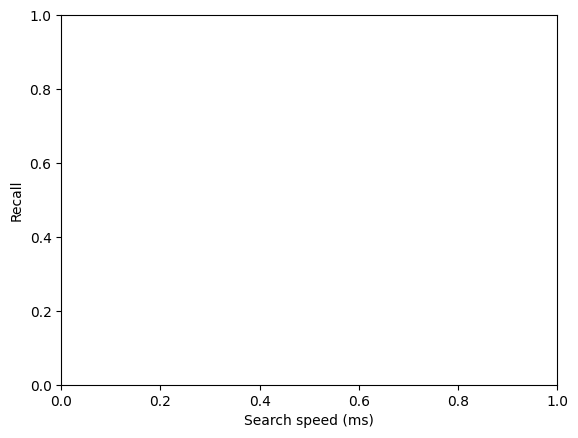

In [259]:
df_plot = df_results.query("Dataset == 'glove-25-angular'")

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_plot,
    x="SearchSpeedAverage",
    y="RecallMean",
    style="Metric",
    hue="TimerBuildIndexMean",
    palette="flare",
    s=70,
)
plt.ylabel("Recall")
plt.xlabel("Search speed (ms)")
plt.show()

In [260]:
df_results.query('Metric == "IP" and Dataset == "glove-25-angular"')

,Unnamed: 0,Dataset,Index,IndexParameters,TimerMasterMean,TimerServerStartupMean,TimerBuildIndexMean,SearchSpeedAverage,SearchSpeedP95,RecallMean,...,BenchmarkingMax,BenchmarkingMean,IndexProvider,IndexType,Compression,EfConstruction,EfSearch,M,Metric,NPartitions


In [261]:
df_results.n

AttributeError: 'DataFrame' object has no attribute 'n'

In [ ]:
df_plot = df_results.query("IndexType == 'IVF'")

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_plot,
    x="Recall avg",
    y="Search speed avg. (ms)",
    style="Metric",
    hue="IndexProvider",
    palette="flare",
    s=70,
)
plt.xlabel("Recall")
plt.ylabel("Search speed (ms)")
plt.show()

: 

In [ ]:
df_plot

: 

In [ ]:
df_plot = df_results.query("IndexType == 'IVF'")

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_plot,
    x="Recall avg",
    y="Search speed avg. (ms)",
    style="Metric",
    hue="nPartitions",
    palette="flare",
    s=70,
)
plt.xlabel("Recall")
plt.ylabel("Search speed (ms)")
plt.show()

: 

In [ ]:
df_results.query("Dataset == ")

: 